In [1]:
!apt-get update
!apt-get install -y libgl1-mesa-glx

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1188 kB]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease                     
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [32.0 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [3046 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1117 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1421 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3597 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/main am

In [2]:
!git clone https://github.com/vislearn/ControlNet-XS

fatal: destination path 'ControlNet-XS' already exists and is not an empty directory.


In [3]:
!pip install -r ControlNet-XS/requirements/pt2.txt -qq
!pip install -e ControlNet-XS -qq

In [14]:
!pip install -Uqq transformers diffusers

___

Restart kernel here, so newly installed packages are available

___

In [1]:
import scripts.control_utils as cu

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


In [2]:
path_to_config = 'ControlNet-XS/configs/inference/sdxl/sdxl_encD_canny_48m.yaml'

### Let's load the `ControlledDiffusionEngine` model (aka the `pipe` in diffusers speak)

If this results in the kernel crashing, I'm using too much GPU memory elsewhere. Shut down every other kernel and try again.

In [3]:
diffeng = cu.create_model(path_to_config)

Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 320, out-chn: 320, kernel-size: 3, stride: 2, padding: 1
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 2048 and using 10 heads with a dimension of 64.
BasicTransformerBlock is using checkpointing
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 2048 and using 10 heads with a dimension of 64.
BasicTransformerBlock is using checkpointing
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEffici

Initialized embedder #0: FrozenCLIPEmbedder with 123060480 params. Trainable: False
Initialized embedder #1: FrozenOpenCLIPEmbedder2 with 694659841 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #3: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #4: ConcatTimestepEmbedderND with 0 params. Trainable: False
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Loaded model config from [ControlNet-XS/configs/inference/sdxl/sdxl_encD_canny_48m.yaml]


In [4]:
type(diffeng)

sgm.models.diffusion.ControlledDiffusionEngine

In [5]:
type(diffeng.model)

sgm.modules.diffusionmodules.twoStreamControl.TwoStreamControlNet

In [6]:
type(diffeng.model.control_model), type(diffeng.model.diffusion_model)

(sgm.modules.diffusionmodules.twoStreamControl.ControlledXLUNetModel,
 sgm.modules.diffusionmodules.openaimodel.UNetModel)

### Load base model

Currently, the base model (`diffeng.model.diffusion_model`) is empty, even though we provided model weights. This is because of mismatching names in the state dicts of our model and the weights.

So, let's fill the mode manually with the weights.

In [7]:
import pickle

In [8]:
with open('state_dict_mapping.pkl', 'rb') as f:
    state_dict_mapping = pickle.load(f)

In [9]:
from diffusers import StableDiffusionXLPipeline

In [10]:
unet = StableDiffusionXLPipeline.from_pretrained('weights/sdxlvae').unet

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [44]:
modified_statedict = diffeng.model.diffusion_model.state_dict()

In [74]:
for k,v in unet.state_dict().items():
    assert v.shape==diffeng.model.diffusion_model.state_dict()[state_dict_mapping[k]].shape
    modified_statedict[state_dict_mapping[k]] = v

In [75]:
diffeng.model.diffusion_model.load_state_dict(modified_statedict)

<All keys matched successfully>

In [53]:
import torch

weight_in_diffusers = unet.state_dict()[k]
weight_in_controlnet= diffeng.model.diffusion_model.state_dict()[state_dict_mapping[k]]

# as sanity check, see if one entry is equal
assert weight_in_diffusers.shape==weight_in_controlnet.shape
assert torch.all((weight_in_diffusers==weight_in_controlnet).bool())

Now, the controlnet-xs model should be loaded correctly, so let's use it!

In [61]:
diffeng = diffeng.to('cuda')

___

Let's first us it without control

In [62]:
diffeng.model.no_control = True

In [63]:
size = 768
num_samples=1

In [64]:
prompt='cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'

In [65]:
def get_canny_edges():
    image_path = 'input_images/shoe.png'
    image = cu.get_image(image_path, size=size)
    edges = cu.get_canny_edges(image, low_th=250, high_th=100)
    return edges

In [66]:
edges = get_canny_edges()

In [71]:
samples, controls = cu.get_sdxl_sample(
    guidance=edges,
    ddim_steps=50,
    num_samples=num_samples,
    model=diffeng,
    shape=[4, size // 8, size // 8],
    control_scale=0.95,
    prompt='cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed',
    n_prompt='lowres, bad anatomy, worst quality, low quality',
)

Global seed set to 1999158951


[CONTROL CORRECTION OF ControlledDiffusionEngine SCALED WITH 0.95]


In [72]:
from PIL import Image

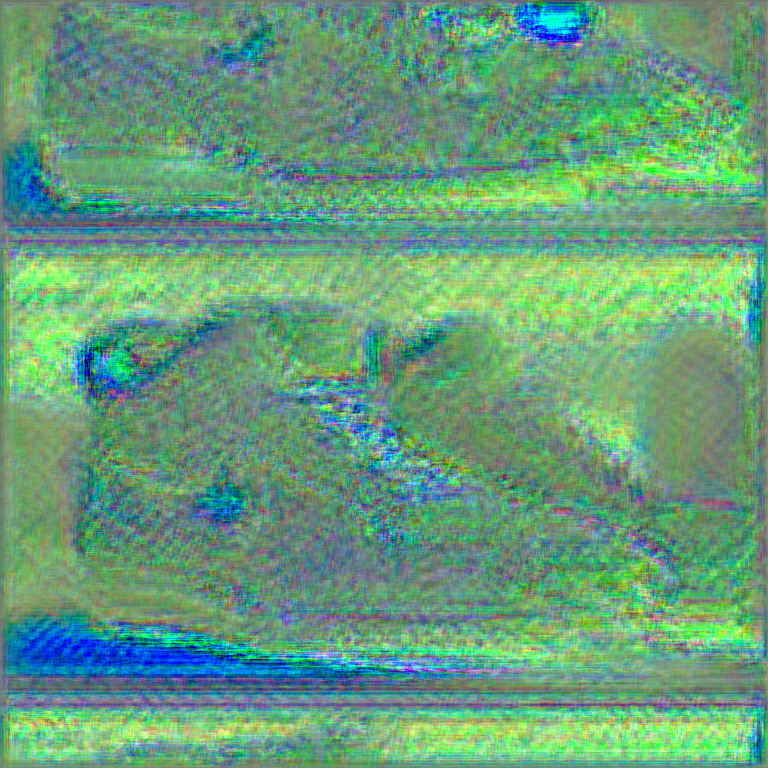

In [73]:
Image.fromarray(cu.create_image_grid(samples))